<div>
<img src="https://www.automation.com/getmedia/3c46e651-52ef-4d7e-9ee1-4e2132173f57/EUS031---Image" width="250" align="left"/>
</div>

## Reinforcement Learning Final Project: Inventory Management
Group 6: Michael, Annie, Targoon

In [1]:
# 1. Problem Introduction
    # - EDA / Markov Process Description
# 2. Solve Problem in a small scale (Value Iteration)
    # - Calculate Probability Matrix & Rewards by simulation
    # - plot different graphs between optimal action vs initial state given different values
# 3. Increase problem scaling (Value Iteration with Simulation & Q-Learning)

### Necessary imports

In [2]:
#!!pip install gym
#!pip install quantecon 
#!pip install numpy==1.19.1

import gym
from gym import spaces
from gym import utils
from gym.utils import seeding

import logging
logger = logging.getLogger(__name__)

import os
from os.path import basename
import sys
import platform

import gym
from gym import spaces
from gym import utils
from gym.utils import seeding

import pandas as pd
import numpy as np
import quantecon as qe

import matplotlib.pyplot as plt

from collections import Counter
from itertools import groupby

import warnings
warnings.filterwarnings("ignore") # supress warnings

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_row', 20) # set max row display
pd.set_option('display.max_columns', 20) # set max column width

# enable ability to see the value of multiple statements at once
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

/Users/colella2/opt/anaconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
# check python version
from platform import python_version
print(python_version())

3.7.7


### Instantiate class from gym environment

In [4]:
class InventoryEnv(gym.Env, utils.EzPickle):
    """Inventory control with lost sales environment

    TO BE EDITED

    This environment corresponds to the version of the inventory control
    with lost sales problem described in Example 1.1 in Algorithms for
    Reinforcement Learning by Csaba Szepesvari (2010).
    https://sites.ualberta.ca/~szepesva/RLBook.html
    """

    # our problem statement does not fully define these parameters
    # we will explain what happens to our optimal policy, given changing parameters -- we will show this w/ graphs
    
    def __init__(self, n=10, k=1, c=2, h=0, p=5, lam=5): # default values
        self.n = n # items held at certain time
        self.action_space = spaces.Discrete(n + 1)
        self.observation_space = spaces.Discrete(n + 1)
        self.max = n # have to optimize max items held at certain time
        self.state = np.random.choice(range(n + 1))
        self.k = k # fixed entry cost for ordering; k must be greater than 0
        self.c = c # fixed price of purchase for items
        self.h = h # proportionality value must be greater than 0; cost per unit; constant that we multiply by remaining inventory
        self.p = p # p is price and must be greater than 0
        self.lam = lam # trace-decay parameter; makes algo incremental
        
        # we do not know what demand will be 
        # upon selling z units the manager is paid the monetary amount of p z, where p > 0.

        # Set seed
        self._seed()

        # Start the first round
        self._reset()

    def demand(self):
        return np.random.poisson(self.lam) # randomly generated demand based on poisson distribution

    # transition probabilities
    def transition(self, x, a, d): # action At gives the number of items ordered in the evening of day t
        # x is initial state
        
        m = self.max
        
        # size of next inventory is xt+1
        return max(min(x + a, m) - d, 0) # subtract the d (demand) that you will recieve the next day

    # a controller receives the controlled system's state and a reward associated with the last state transition
    def reward(self, x, a, y):
        k = self.k
        m = self.max # m is equal to n
        c = self.c
        h = self.h
        p = self.p
        
        # a, amount purchased, + max inventory; if over amount of storage, affix penalty
        if a + x > self.max:
            return -99999
        else:
            r = -k * (a > 0) - c * max(min(x + a, m) - x, 0) - h * x + p * max(min(x + a, m) - y, 0)
            return r

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _step(self, action):
        assert self.action_space.contains(action)
        obs = self.state
        demand = self.demand()
        obs2 = self.transition(obs, action, demand)
        self.state = obs2
        reward = self.reward(obs, action, obs2)
        done = 0
        return obs2, reward, done, {}

    def _reset(self):
        return self.state

We are going to start with a smaller sample set.

### Step 1: Transition probability and Reward matrices

In [5]:
env = InventoryEnv()
env.n

10

In [6]:
#env = updated gym env
#T= simulated demand iterations 

def transition_prob(env,T=10000):
  P_t = np.zeros([env.n + 1, env.n + 1, env.n + 1]) #(action, current_state, next_state)
  RR = np.zeros([env.n + 1, env.n + 1, env.n + 1]) 
  print('Shape of probability matrix and Reward Matrix is',RR.shape)

  demand_list = []
  for init_state in range(env.n + 1):
      for action in range(env.n + 1):
          final_state_list = []

          for i in range(T):
              demand = env.demand()
              final_state = env.transition(init_state, action, demand)
              
              demand_list.append(demand)
              final_state_list.append(final_state)
              
          final_state_count = Counter(final_state_list)
          
          
          for (final_state,probability) in final_state_count.items():
              P_t[action, init_state, final_state] = probability / T
              
          for final_state in range(env.n + 1):
              RR[action, init_state, final_state] = env.reward(init_state, action, final_state)

  return P_t,RR,demand_list

In [7]:
P_t,RR,demand_list = transition_prob(env)

Shape of probability matrix and Reward Matrix is (11, 11, 11)


(array([4.88510e+04, 2.71375e+05, 4.25278e+05, 3.02700e+05, 1.23497e+05,
        3.16850e+04, 5.75300e+03, 7.70000e+02, 8.30000e+01, 8.00000e+00]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

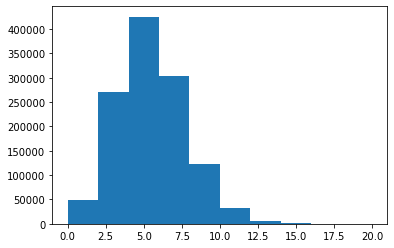

In [8]:
plt.hist(demand_list)

In [9]:
pd.DataFrame(P_t[5,:,:])

,0,1,2,3,4,5,6,7,8,9,10
0,0.5620,0.1748,0.1394,0.0823,0.0354,0.0061,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.3928,0.1702,0.1697,0.1399,0.0835,0.0353,0.0086,0.0000,0.0000,0.0000,0.0000
2,0.2395,0.1469,0.1794,0.1726,0.1397,0.0801,0.0350,0.0068,0.0000,0.0000,0.0000
3,0.1311,0.1094,0.1457,0.1754,0.1768,0.1363,0.0879,0.0319,0.0055,0.0000,0.0000
4,0.0670,0.0630,0.1116,0.1403,0.1752,0.1803,0.1390,0.0864,0.0309,0.0063,0.0000
5,0.0294,0.0351,0.0631,0.1057,0.1485,0.1735,0.1752,0.1417,0.0857,0.0362,0.0059
6,0.0316,0.0384,0.0643,0.0987,0.1464,0.1732,0.1769,0.1395,0.0899,0.0347,0.0064
7,0.0298,0.0354,0.0628,0.1004,0.1481,0.1783,0.1766,0.1431,0.0844,0.0344,0.0067
8,0.0326,0.0373,0.0652,0.1039,0.1461,0.1800,0.1748,0.1373,0.0813,0.0342,0.0073
9,0.0308,0.0340,0.0641,0.1039,0.1414,0.1792,0.1820,0.1397,0.0839,0.0324,0.0086


In [10]:
K,N,M = P_t.shape
K,N,M

(11, 11, 11)

In [11]:
# k = action
# i = current state
# j = next state

### Step 2: EDA

 - We are starting with action 0, which is ordering nothing, which means that there is nothing in inventory
 - This means that demand is being realized in every step that we are taking

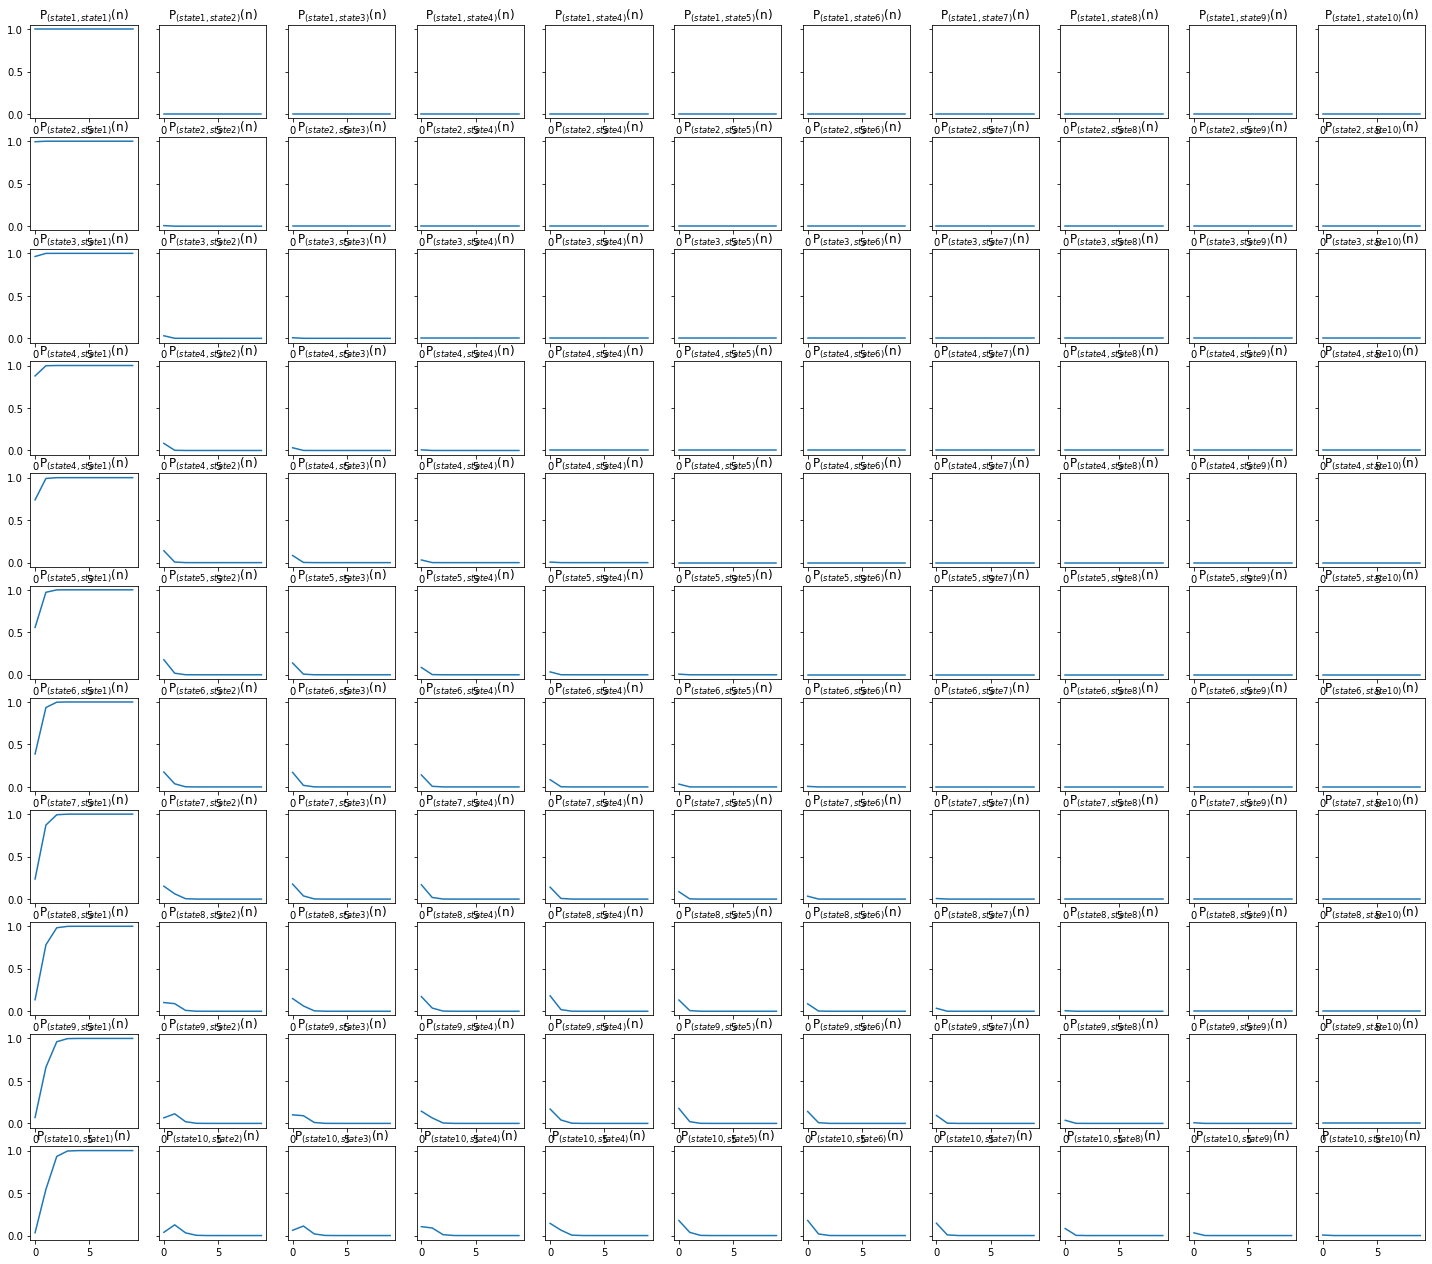

In [43]:
P_t[0,:,:].shape

prob_matrix = P_t[0]

# define # of periods / decision epochs / stages
T = 10

# define # of rows & cols
n = 11

# create array for storing transition probs
P = np.zeros((T,n,n),dtype=np.float64) # reflects steps 0 through 99

P.shape


# take array of 0's and set equal to first set of transition probabilities
P[0] = prob_matrix
P[0]


for item in range(1,T):
    P[item] = np.matmul(P[item - 1], prob_matrix)
    
    
# map actions
states = {
    
    0:'state1', 
    1:'state2', 
    2:'state3', 
    3:'state4', 
    4:'state4', 
    5:'state5', 
    6:'state6', 
    7:'state7',
    8:'state8',
    9:'state9',
    10:'state10'
    
}


# plot
fig, axes = plt.subplots(n, n, figsize=(25, 25), sharey = True)

for i in range(n):
    
    for j in range(n):
        
        var_name = '({},{})'.format(states[i],states[j])
        
        plt.sca(axes[i, j]) 
        plt.plot(range(T), P[:,i,j])
        
        axes[i,j].set_title(f'P$_{{{var_name}}}$(n)')

fig.subplots_adjust(top = 0.8)
plt.show()

Text(0, 0.5, 'states')

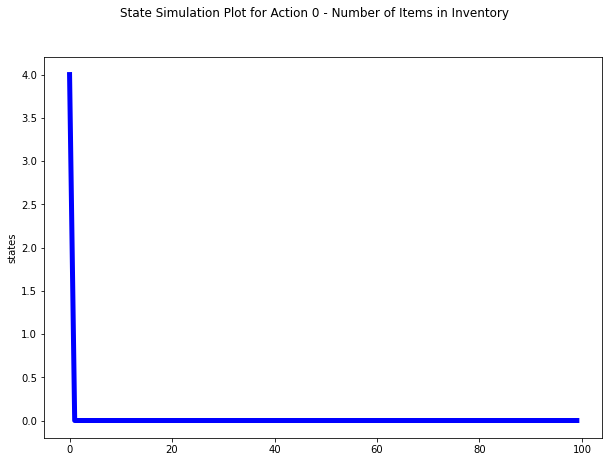

In [29]:
im_states1 = qe.MarkovChain(P_t[0,:,:])

simulations = 100

simulation = im_states1.simulate(simulations, random_state = 33)

# plot sequence of transitions as step function of time

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
fig.suptitle('State Simulation Plot for Action 0 - Number of Items in Inventory')

plt.plot(simulation, lw = 5, color = 'b')

plt.ylabel('states')

# this is what we would expect when not ordering anything

 - Here we are starting with action 5, which means we are ordering 5 items
 - Here, we are still converging relatively quickly
 - There is some variation in how exactly that convergence happens; actual ordering is occurring

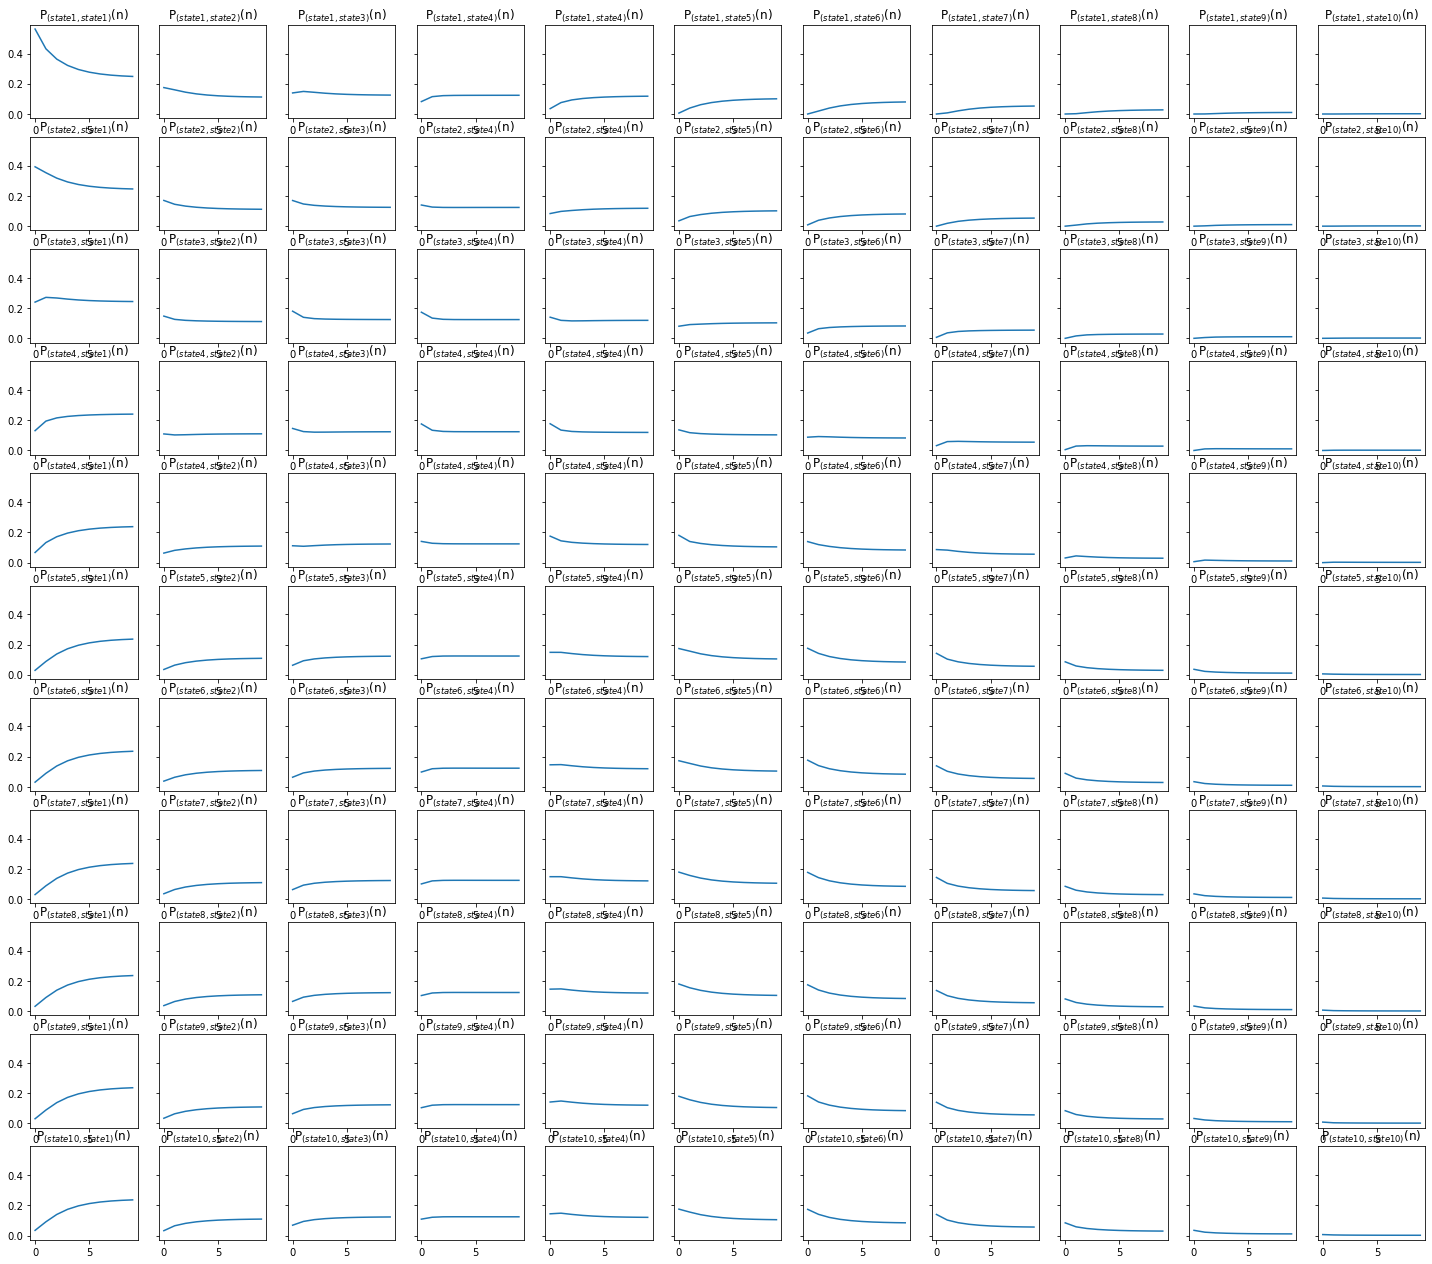

In [58]:
P_t[5,:,:] # use array 5th array as example

P_t[5,:,:].shape

prob_matrix = P_t[5]


# define # of periods / decision epochs / stages
T = 10

# define # of rows & cols
n = 11

# create array for storing transition probs
P = np.zeros((T,n,n),dtype=np.float64) # reflects steps 0 through 99


# take array of 0's and set equal to first set of transition probabilities
P[0] = prob_matrix

for item in range(1,T):
    P[item] = np.matmul(P[item - 1], prob_matrix)


# plot
fig, axes = plt.subplots(n, n, figsize=(25, 25), sharey = True)

for i in range(n):
    
    for j in range(n):
        
        var_name = '({},{})'.format(states[i],states[j])
        
        plt.sca(axes[i, j]) 
        plt.plot(range(T), P[:,i,j])
        
        axes[i,j].set_title(f'P$_{{{var_name}}}$(n)')

fig.subplots_adjust(top = 0.8)
plt.show()

In [59]:
# group all states into classes; report the classes and the total number of classes

im_states3 = qe.MarkovChain(prob_matrix)

# calculate communication classes
print(im_states3.communication_classes) 

# get # of classes
len(im_states3.communication_classes)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])]


1

In [60]:
print(im_states3.is_irreducible)

True


In [61]:
# periodicity
im_states3 = qe.MarkovChain(prob_matrix)

# calculate # of periods
im_states3.period

1

In [62]:
# since the # of periods = 1, this means the matrix is aperiodic, something confirmed by 
# the plots with no discernable pattern

# shows matrix is aperiodic
im_states3.is_aperiodic 

True

In [63]:
# simulation

# construct a 100-step simulation assuming an intial state and the above transition matrix
simulations = 100

simulation = im_states3.simulate(simulations, random_state = 33)
simulation

array([4, 5, 6, 8, 2, 4, 5, 7, 8, 0, 2, 0, 4, 4, 1, 3, 7, 2, 0, 0, 2, 4,
       2, 1, 1, 1, 0, 0, 3, 4, 3, 4, 8, 6, 5, 1, 1, 0, 0, 3, 0, 0, 1, 0,
       0, 0, 0, 0, 3, 5, 9, 7, 8, 7, 9, 3, 1, 3, 4, 8, 4, 4, 7, 8, 5, 7,
       6, 8, 4, 4, 6, 6, 0, 0, 2, 2, 4, 6, 7, 9, 5, 5, 6, 3, 3, 3, 1, 0,
       0, 4, 2, 0, 1, 0, 1, 0, 0, 1, 1, 1])

Text(0, 0.5, 'states')

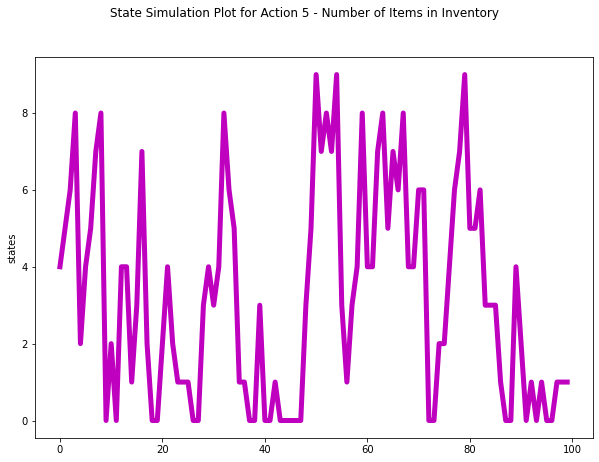

In [64]:
# plot sequence of transitions as step function of time

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
fig.suptitle('State Simulation Plot for Action 5 - Number of Items in Inventory')

plt.plot(simulation, lw = 5, color = 'm')

plt.ylabel('states')

 - Here we are starting with action 10, which means we are ordering 10 items
 - Here, we are still converging relatively quickly
 - There is some variation in how exactly that convergence happens; actual ordering is occurring

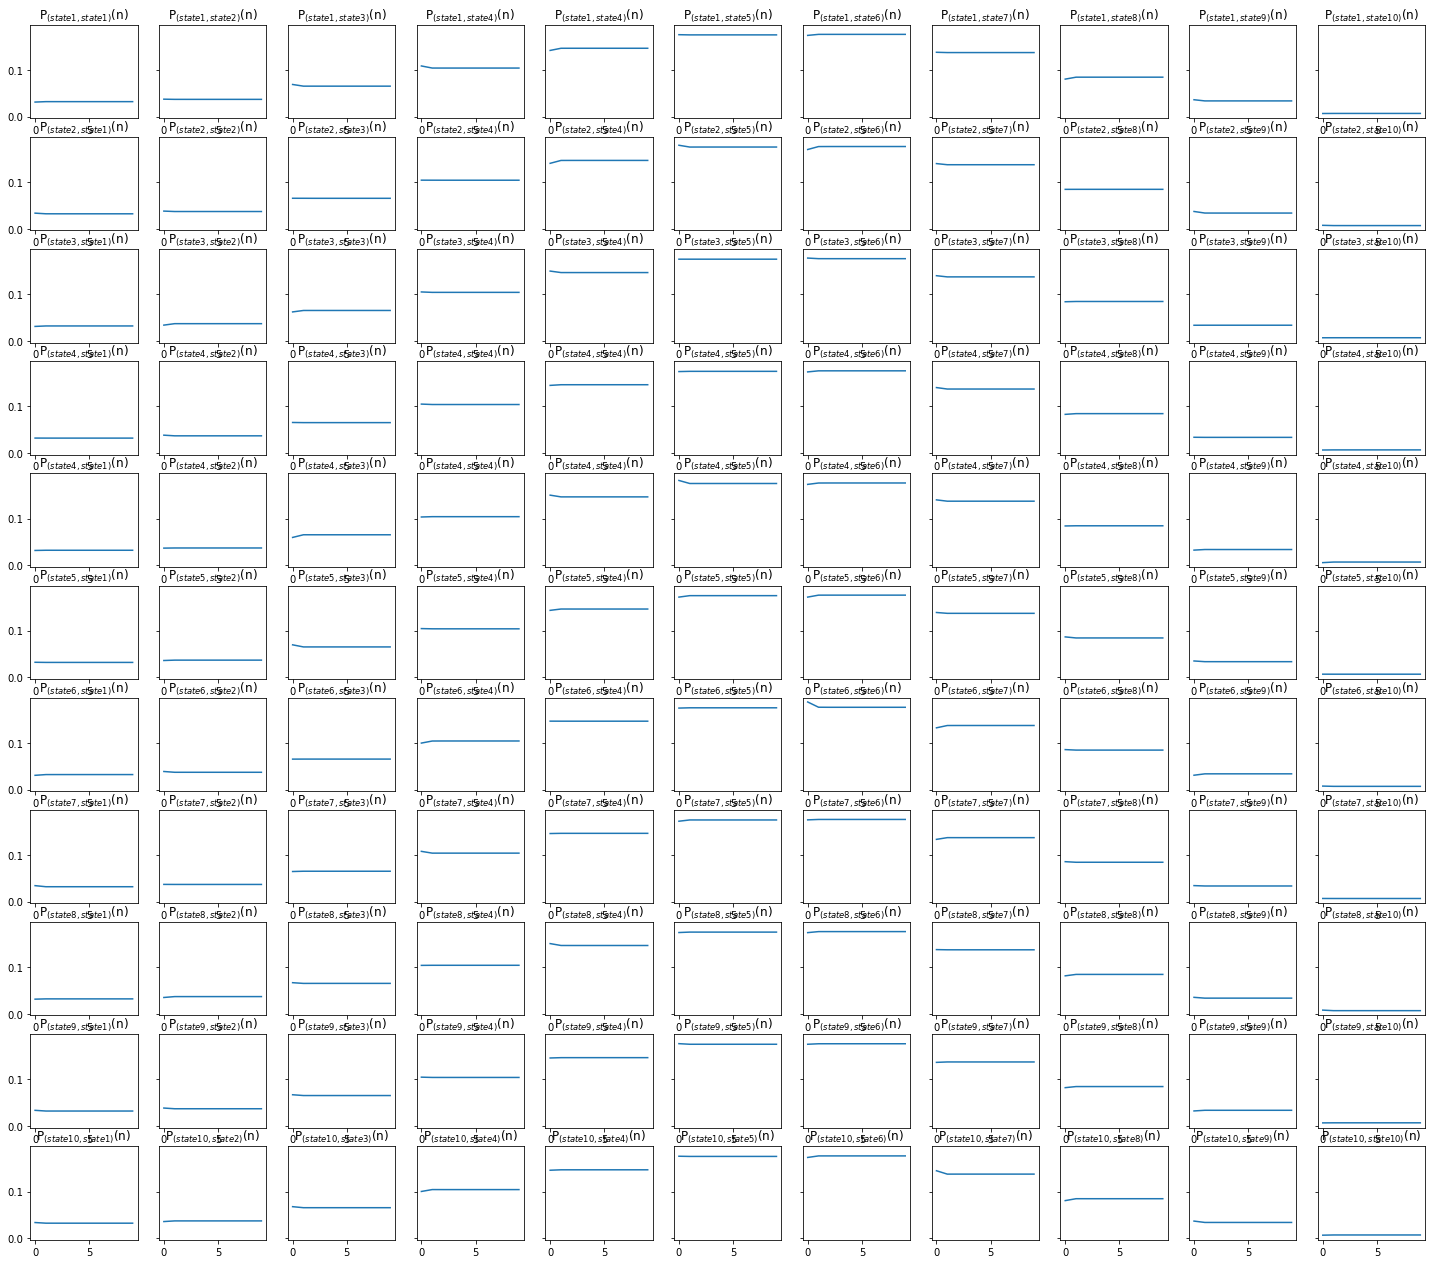

In [38]:
P_t[10,:,:].shape

prob_matrix = P_t[10]


# define # of periods / decision epochs / stages
T = 10

# define # of rows & cols
n = 11

# create array for storing transition probs
P = np.zeros((T,n,n),dtype=np.float64) # reflects steps 0 through 99

# take array of 0's and set equal to first set of transition probabilities
P[0] = prob_matrix
P[0]

for item in range(1,T):
    P[item] = np.matmul(P[item - 1], prob_matrix)
    

# plot
fig, axes = plt.subplots(n, n, figsize=(25, 25), sharey = True)

for i in range(n):
    
    for j in range(n):
        
        var_name = '({},{})'.format(states[i],states[j])
        
        plt.sca(axes[i, j]) 
        plt.plot(range(T), P[:,i,j])
        
        axes[i,j].set_title(f'P$_{{{var_name}}}$(n)')

fig.subplots_adjust(top = 0.8)
plt.show()

Text(0, 0.5, 'states')

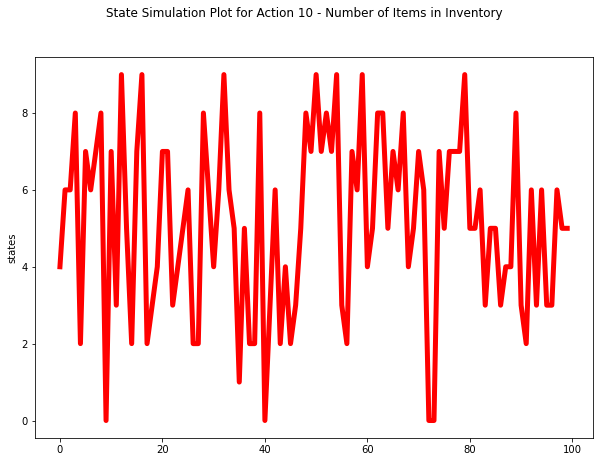

In [39]:
im_states4 = qe.MarkovChain(P_t[10,:,:])

# remove variable names for credit ratings
im_states4 = qe.MarkovChain(P_t[10,:,:])

simulations = 100

simulation = im_states4.simulate(simulations, random_state = 33)

# plot sequence of transitions as step function of time

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
fig.suptitle('State Simulation Plot for Action 10 - Number of Items in Inventory')

plt.plot(simulation, lw = 5, color = 'r')

plt.ylabel('states')

# this is what we would expect when not ordering anything

 - Report the likehood of each transition and the likelihood of the entire simulated sequence for ***ACTION 5***
 (re-run section above for Action 5 before proceeding)

In [66]:
# sequence probability for all steps -- 100
probability = 1

# transition probability set
prob_set = []


for i in range(1, simulations):
    
    # current state -- first state
    c_s = simulation[i - 1]
    
    # following state -- second state
    f_s = simulation[i]
    
    # transition probability
    prob_set2 = prob_matrix[c_s,f_s]
    prob_set2 = round(prob_set2,3)
    
    # append new transition probabilities
    prob_set.append(((c_s, f_s), prob_set2))
    
    # multiply sequence probabilities by calculated probabilities
    probability *= prob_set2

In [67]:
# likelihood of each transition
prob_set

[((4, 5), 0.18),
 ((5, 6), 0.175),
 ((6, 8), 0.09),
 ((8, 2), 0.065),
 ((2, 4), 0.14),
 ((4, 5), 0.18),
 ((5, 7), 0.142),
 ((7, 8), 0.084),
 ((8, 0), 0.033),
 ((0, 2), 0.139),
 ((2, 0), 0.24),
 ((0, 4), 0.035),
 ((4, 4), 0.175),
 ((4, 1), 0.063),
 ((1, 3), 0.14),
 ((3, 7), 0.032),
 ((7, 2), 0.063),
 ((2, 0), 0.24),
 ((0, 0), 0.562),
 ((0, 2), 0.139),
 ((2, 4), 0.14),
 ((4, 2), 0.112),
 ((2, 1), 0.147),
 ((1, 1), 0.17),
 ((1, 1), 0.17),
 ((1, 0), 0.393),
 ((0, 0), 0.562),
 ((0, 3), 0.082),
 ((3, 4), 0.177),
 ((4, 3), 0.14),
 ((3, 4), 0.177),
 ((4, 8), 0.031),
 ((8, 6), 0.175),
 ((6, 5), 0.173),
 ((5, 1), 0.035),
 ((1, 1), 0.17),
 ((1, 0), 0.393),
 ((0, 0), 0.562),
 ((0, 3), 0.082),
 ((3, 0), 0.131),
 ((0, 0), 0.562),
 ((0, 1), 0.175),
 ((1, 0), 0.393),
 ((0, 0), 0.562),
 ((0, 0), 0.562),
 ((0, 0), 0.562),
 ((0, 0), 0.562),
 ((0, 3), 0.082),
 ((3, 5), 0.136),
 ((5, 9), 0.036),
 ((9, 7), 0.14),
 ((7, 8), 0.084),
 ((8, 7), 0.137),
 ((7, 9), 0.034),
 ((9, 3), 0.104),
 ((3, 1), 0.109),
 ((1,

In [68]:
# likelihood of entire simulated sequencen (total):
probability

6.350682654279713e-83

 - Examine stationarity: is this Markov chain ***stationary***?

In [69]:
# stationarity

# stationary distribution

a = np.ones((n,)) 
b = np.ones((n, n))

i = np.identity(11)

p = np.matmul(a,np.linalg.inv(i - prob_matrix + b)) 
# linalg.inv() calculates inverse of matrix
# inverse of a matrix is such that if multiplied by original matrix, results in identity
# matrix
# identity matrix is square matrix with ones on main diagonal

p

array([0.24178747, 0.11053516, 0.12392706, 0.12394759, 0.11922287,
       0.10285933, 0.0821859 , 0.05460074, 0.02853789, 0.01058615,
       0.00180982])

In [70]:
# can confirm stationary by multiplying by transition probability matrix
p = np.matmul(p, prob_matrix)
p

array([0.24178747, 0.11053516, 0.12392706, 0.12394759, 0.11922287,
       0.10285933, 0.0821859 , 0.05460074, 0.02853789, 0.01058615,
       0.00180982])

In [72]:
# confirm stationarity with quant econ function
im_states3.stationary_distributions

# stationary distrib. of a Markov chain is a prob. distrib. that remains unchanged in the 
# Markov chain over time

# Markov chain is stationary b/c of existence of stationary distribution & b/c it satisfies 
# mathematical condition of pi^T = pi^T * P. pi is a row vector with probabilities that sum 
# to 1

array([[0.24178747, 0.11053516, 0.12392706, 0.12394759, 0.11922287,
        0.10285933, 0.0821859 , 0.05460074, 0.02853789, 0.01058615,
        0.00180982]])

 - Is this Markov chain time homogeneous?

In [74]:
# The Markov chain is homogeneous due to stationarity of transition probabilities. So, the
# probability of visiting a future state only depends on present state. The probability 
# transition matrix does not depend on time. The probability of visiting a future state is
# equal given any current state.

In [ ]:
# recurrent states -- including explanation(s)




### Step 3: Value Iteration (Bellman back-up)
 - Given optimal actions across a time horizon, considers expected sum of rewards after starting from a specific state
 - Method of computing an optimal MDP policy and its value
 - Starts at arbitrary end-point & works backward, refining estimate of V
 - Output: approximate optimal policy
 -  S states, A actions, P transition f(x) for P(s'|s,a), R reward f(x) given (s,a,s') and theta, a pre-defined threshold
     -  Smaller the threshold, the higher the precision
     - Utility values need to converge
     - Calculates expected utility of each state using utilities of tneighboring states until utilities calculated on two successive steps are close enough

In [ ]:
def value_iteration(P_t,RR,t=600):
    
  K,N,M = P_t.shape
  q = np.zeros((K,N,1),dtype=np.float64)
  # print(q)
    
  print('The shape of K,N,M is:', K,N,M) 
  print('The shape of q is:',q.shape) # creates eleven 11 x 1 arrays
    
  for i in range(0,N):
    for k in range(0,K):
        for j in range(0,M):
            q[k,i,0] = q[k,i,0] + RR[k,i,j]*P_t[k,i,j]

  v = np.zeros((N,t),dtype=np.float64)
  d = np.zeros((N,t),dtype=np.float64)
    
  for n in range(1,t):   
      for i in range(0,N):
          rhs = np.zeros((1,K),dtype=np.float64)
        
          for k in range(0,K):
              rhs[0][k] = q[k][i][0] + np.matmul(P_t[k,i,:],v[:,n-1]) 
            
          v[i,n] = max(rhs[0])
          d[i,n] = np.argmax(rhs[0])
  
  v = v.T
  d = d.T

  return v,d

In [ ]:
v,d=value_iteration(P_t,RR)

In [ ]:
value_df = pd.DataFrame(v)
value_df

In [ ]:
policy_df = pd.DataFrame(d)
policy_df.tail(10)

### Step 4: Value Iteration by Simulation

In [ ]:
a = P_t.sum(axis=1)
a.shape

In [ ]:
pd.DataFrame(a)

In [ ]:
a.sum(axis=1)

In [ ]:
np.set_printoptions(precision=15)

In [ ]:
P_t[9,:,:]

In [ ]:
#T= number of episodes 
# maximum number of transitions (=maximum number of simulations -1)


def val_iter_sim(P_mat,RR,T=1000,Tmax=1000):
  K,N,M = P_t.shape
  # compute the expected reward (immediate)
  q = np.zeros((K,N,1),dtype=np.float64)

  for i in range(0,N):
      for k in range(0,K):
          for j in range(0,M):
              q[k,i,0] = q[k,i,0] + RR[k,i,j]*P_t[k,i,j]


  v = np.zeros((N,T+1),dtype=np.float64)
  d = np.zeros((N,T+1),dtype=np.int)
  visits = np.zeros((N,1),dtype=np.int)



  for n in range(1,T):
      t = 1
      y0 = N-1
      while (t<=Tmax+1):
          visits[y0]+=1
          for i in range(0,N):
              if i==y0:
                  rhs = np.zeros((1,K),dtype=np.float64)
                  for k in range(0,K):
                      rhs[0][k] = q[k][i][0] + np.matmul(P_t[k,i,:],v[:,n-1]) 
                  v[i,n] = max(rhs[0])
                  if np.random.uniform(0,1,1)>=0.1:
                      d[i,n] = np.argmax(rhs[0])
                  else:
                      d[i,n] = np.random.choice(range(0,K))
          y1 = np.random.choice(range(0,N),p=P_t[d[y0,n],y0,:])
          y0 = y1
          t = t+1
      v[:,n+1] = v[:,n]
      d[:,n+1] = d[:,n]
      
  v = v.T
  d = d.T
  return v,d, visits

In [ ]:
%%time

v,d,visits=val_iter_sim(P_t,RR)

In [ ]:
pd.DataFrame(d)

### Step 5: Q (Quality)-Learning
 - Off-policy RL technique that searches for the best action to take given a current state; aimed at maximizing total reward
     - Off-policy b/c Q function learns from actions outside current policy (e.g., taking random actions)
 - Quality refers to usefulness of an action in terms of earning a reward
 - Necessitates creation of q-table (reference table for agent to select optimal action) with (state, action) form 
     - Values initialized to 0
     - Update q-values post each episode
 - Can explore or exploit
     - Exploit: given universe of possible actions for given state, selects action based on max value
     - Explore: random actions based on discovery

In [ ]:
# Tmax=maximum number of transitions (=maximum number of simulations -1)

def Q_learning(env=env,lr=0.01,Tmax=1000,T=1000):

  v = np.zeros((env.n + 1,T+1),dtype=np.float64) #value
  d = np.zeros((env.n + 1,T+1),dtype=np.int) #policy
  visits = np.zeros((env.n + 1,env.n + 1),dtype=np.int) #current/action

  Q = np.zeros((env.n + 1,env.n + 1),dtype=np.float64)

  learning_rate = lr
  for num_ep in range(1,T):
      t = 1
      current_state = env.state
      while (t <= Tmax+1):
          if t < Tmax / 2:
              if np.random.uniform(0,1,1)>=((Tmax - t) / Tmax):
                  action = np.argmax(Q[current_state,:]) #greedy
              else:
                  action = np.random.choice(range(0,K)) #explore
          else:
              action = np.argmax(Q[current_state,:]) #greedy
          visits[current_state,action]+=1
          #print("state: " + str(env.state))
          next_state, reward, done, z = env._step(action)
          #print("action: " + str(action))
          #print("next state: " + str(env.state))
          
          Q[current_state,action] = (1-learning_rate)*Q[current_state,action] + learning_rate*(reward + 
                                                                              0.99 * max(Q[next_state,:]))      
          current_state = env.state
          t += 1
          
  J = np.zeros((env.n + 1,1),dtype=np.float64)
  d = np.zeros((env.n + 1,1),dtype=np.float64)
  for j in range(0,env.n + 1):
      J[j,0] = max(Q[j,:])
      d[j,0] = np.argmax(Q[j,:])
  return Q,J,d

In [ ]:
Q,J,d=Q_learning()

In [ ]:
pd.DataFrame(Q)

In [ ]:
pd.DataFrame(d)

### Step 6: Q Learning using Prob Matrix

In [ ]:
# T number of episodes
# Tmax = 1000
#  gamma = 0.1

T=50000
Tmax=10000
gamma=0.05

def Q_learn_pmat(P_t,RR,T=5000,Tmax=1000,gamma=0.1,discount_rate=0.95):
  K,N,M = P_t.shape
  v = np.zeros((N,T+1),dtype=np.float64) #value
  d = np.zeros((N,T+1),dtype=np.int) #policy
  visits = np.zeros((N,K),dtype=np.int)

  Q = np.zeros((N,K),dtype=np.float64)

  # maximum number of transitions (=maximum number of simulations -1)

  for num_ep in range(1,T):
      t = 1
      y0 = np.random.choice(range(0,N))
      d0 = np.random.choice(range(0,K))
      while (t<=Tmax+1):
          visits[y0,d0]+=1
          y1 = np.random.choice(range(0,N),p=P_t[d0,y0,:])
          Q[y0,d0] = (1-gamma)*Q[y0,d0] + gamma*(RR[d0,y0,y1] + discount_rate * max(Q[y1,:]))
          y0 = y1
          if np.random.uniform(0,1,1)>=0.2:
              d0 = np.argmax(Q[y1,:]) #greedy
          else:
              d0 = np.random.choice(range(0,K)) #explore
          t = t+1


  J = np.zeros((N,1),dtype=np.float64)
  d = np.zeros((N,1),dtype=np.float64)
  for j in range(0,N):
      J[j,0] = max(Q[j,:])
      d[j,0] = np.argmax(Q[j,:])
  return J,d,visits,Q

In [ ]:
J,d,visits,Q=Q_learn_pmat(P_t,RR)

In [ ]:
policy_df = pd.DataFrame(d)

In [ ]:
pd.DataFrame(Q)

In [ ]:
policy_df

### Step 7: Experiment with a large n (100 units in inventory)

In [ ]:
env = InventoryEnv()
env.n

In [ ]:
P_t,RR,demand_list = transition_prob(env)
plt.hist(demand_list)

In [ ]:
pd.DataFrame(P_t[5,:,:]) #transition matrix at action = 5

In [ ]:
K,N,M = P_t.shape
K,N,M

In [ ]:
v,d=value_iteration(P_t,RR)

In [ ]:
value_df = pd.DataFrame(v)
value_df

In [ ]:
policy_df = pd.DataFrame(d)
policy_df

In [ ]:
v,d,visits=val_iter_sim(P_t,RR)

In [ ]:
pd.DataFrame(d)

In [ ]:
Q,J,d=Q_learning()

In [ ]:
pd.DataFrame(Q)

In [ ]:
pd.DataFrame(d)

In [ ]:
J,d,visits,Q=Q_learn_pmat(P_t,RR)

In [ ]:
policy_df = pd.DataFrame(d)
policy_df

In [ ]:
pd.DataFrame(Q)